In [1]:
import warnings
warnings.simplefilter('ignore')

## 0. Install and import dependencies

In [2]:
# if already installed do not run ! :
#!pip install pystan prophet plotly Cython

In [3]:
import pandas as pd
from prophet import Prophet 
%matplotlib inline

## 1. Read in Data and process dates

In [4]:
df = pd.read_csv('dataset.csv')

In [5]:
df.head()

,Time Date,Product,Store,Value
0,1012018,2667437,QLD_CW_ST0203,2926.000
1,2012018,2667437,QLD_CW_ST0203,2687.531
2,3012018,2667437,QLD_CW_ST0203,2793.000
3,4012018,2667437,QLD_CW_ST0203,2394.000
4,5012018,2667437,QLD_CW_ST0203,2660.000


In [6]:
df.describe()

,Time Date,Product,Value
count,1.080000e+03,1080.0,1080.000000
mean,1.567207e+07,2667437.0,4048.117478
std,8.791548e+06,0.0,1439.945783
min,1.012018e+06,2667437.0,2042.813500
25%,8.069518e+06,2667437.0,2632.498599
50%,1.556702e+07,2667437.0,4256.000000
75%,2.308452e+07,2667437.0,5288.248910
max,3.112202e+07,2667437.0,8147.739600


In [7]:
# check how many products and stores there are in the table
print(df['Store'].unique())
print(df['Product'].unique())

['QLD_CW_ST0203']
[2667437]


In [8]:
df.dtypes

Time Date      int64
Product        int64
Store         object
Value        float64
dtype: object

- - We need Time Date to be a (DateTime value) not Int64 type 

In [9]:
# Extracting Date
df['Year'] = df['Time Date'].apply(lambda x : str(x)[-4:])
df['Month'] = df['Time Date'].apply(lambda x : str(x)[-6:-4])
df['Day'] = df['Time Date'].apply(lambda x : str(x)[:-6])

# Formating Date
df['ds'] = pd.DatetimeIndex(df['Year']+'-'+df['Month']+'-'+df['Day']) #  To box subclasses of datetime to Timestamp objects 

In [10]:
df.head()

,Time Date,Product,Store,Value,Year,Month,Day,ds
0,1012018,2667437,QLD_CW_ST0203,2926.000,2018,01,1,2018-01-01
1,2012018,2667437,QLD_CW_ST0203,2687.531,2018,01,2,2018-01-02
2,3012018,2667437,QLD_CW_ST0203,2793.000,2018,01,3,2018-01-03
3,4012018,2667437,QLD_CW_ST0203,2394.000,2018,01,4,2018-01-04
4,5012018,2667437,QLD_CW_ST0203,2660.000,2018,01,5,2018-01-05


In [11]:
df.dtypes

Time Date             int64
Product               int64
Store                object
Value               float64
Year                 object
Month                object
Day                  object
ds           datetime64[ns]
dtype: object

- - We cand drop Time Date col because we do not need it anymore, 
- drop (Product / Store) because they are unique values
- drop Year, Month Day because we a a new Datetime object

In [12]:
# drop unnecessary
df.drop(['Year','Month','Day','Store','Product','Time Date'], axis=1, inplace=True)
# rename existing ones
df.columns = ['y','ds'] # values, datetime

In [13]:
df.head()

,y,ds
0,2926.000,2018-01-01
1,2687.531,2018-01-02
2,2793.000,2018-01-03
3,2394.000,2018-01-04
4,2660.000,2018-01-05


## 2. Train Model

In [14]:
# instantiate model
m = Prophet(interval_width=0.95, daily_seasonality=True) #confidence interval, days
# fit it
model = m.fit(df)

10:59:56 - cmdstanpy - INFO - Chain [1] start processing
10:59:57 - cmdstanpy - INFO - Chain [1] done processing


## 3. Forecast Away

In [15]:
future = m.make_future_dataframe(periods=100, freq='D') # define future condition
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01,3042.838536,820.152088,4094.034965,3042.838536,3042.838536,-637.679182,-637.679182,-637.679182,472.992579,...,16.626945,16.626945,16.626945,-1127.298706,-1127.298706,-1127.298706,0.0,0.0,0.0,2405.159354
1,2018-01-02,3043.562716,949.623757,4074.181976,3043.562716,3043.562716,-647.909273,-647.909273,-647.909273,472.992579,...,-11.279710,-11.279710,-11.279710,-1109.622142,-1109.622142,-1109.622142,0.0,0.0,0.0,2395.653442
2,2018-01-03,3044.286896,915.414600,3941.329541,3044.286896,3044.286896,-622.172091,-622.172091,-622.172091,472.992579,...,-4.410885,-4.410885,-4.410885,-1090.753785,-1090.753785,-1090.753785,0.0,0.0,0.0,2422.114805
3,2018-01-04,3045.011076,822.420862,3984.898500,3045.011076,3045.011076,-575.273205,-575.273205,-575.273205,472.992579,...,22.503323,22.503323,22.503323,-1070.769108,-1070.769108,-1070.769108,0.0,0.0,0.0,2469.737871
4,2018-01-05,3045.735256,784.027928,4063.942635,3045.735256,3045.735256,-611.368588,-611.368588,-611.368588,472.992579,...,-34.564705,-34.564705,-34.564705,-1049.796462,-1049.796462,-1049.796462,0.0,0.0,0.0,2434.366668


- - returns upper/lower estimates, yhat=prediction

In [16]:
forecast[['ds','yhat']]

,ds,yhat
0,2018-01-01,2405.159354
1,2018-01-02,2395.653442
2,2018-01-03,2422.114805
3,2018-01-04,2469.737871
4,2018-01-05,2434.366668
...,...,...
1175,2021-03-22,3727.337868
1176,2021-03-23,3710.974804
1177,2021-03-24,3726.610253
1178,2021-03-25,3758.930959


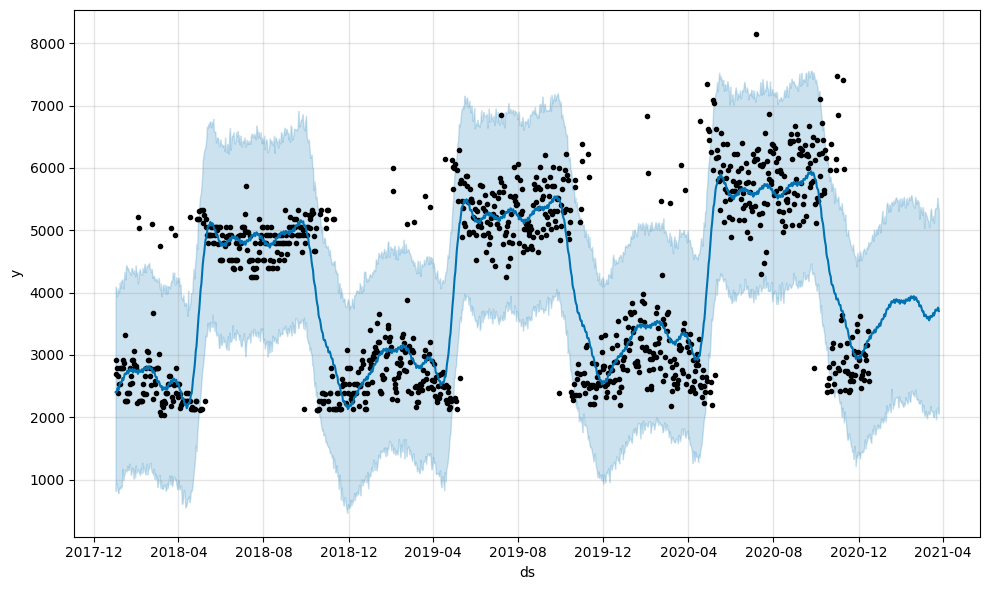

In [17]:
plot1 = m.plot(forecast)

- - You see there are picks in value (y) every 4 months

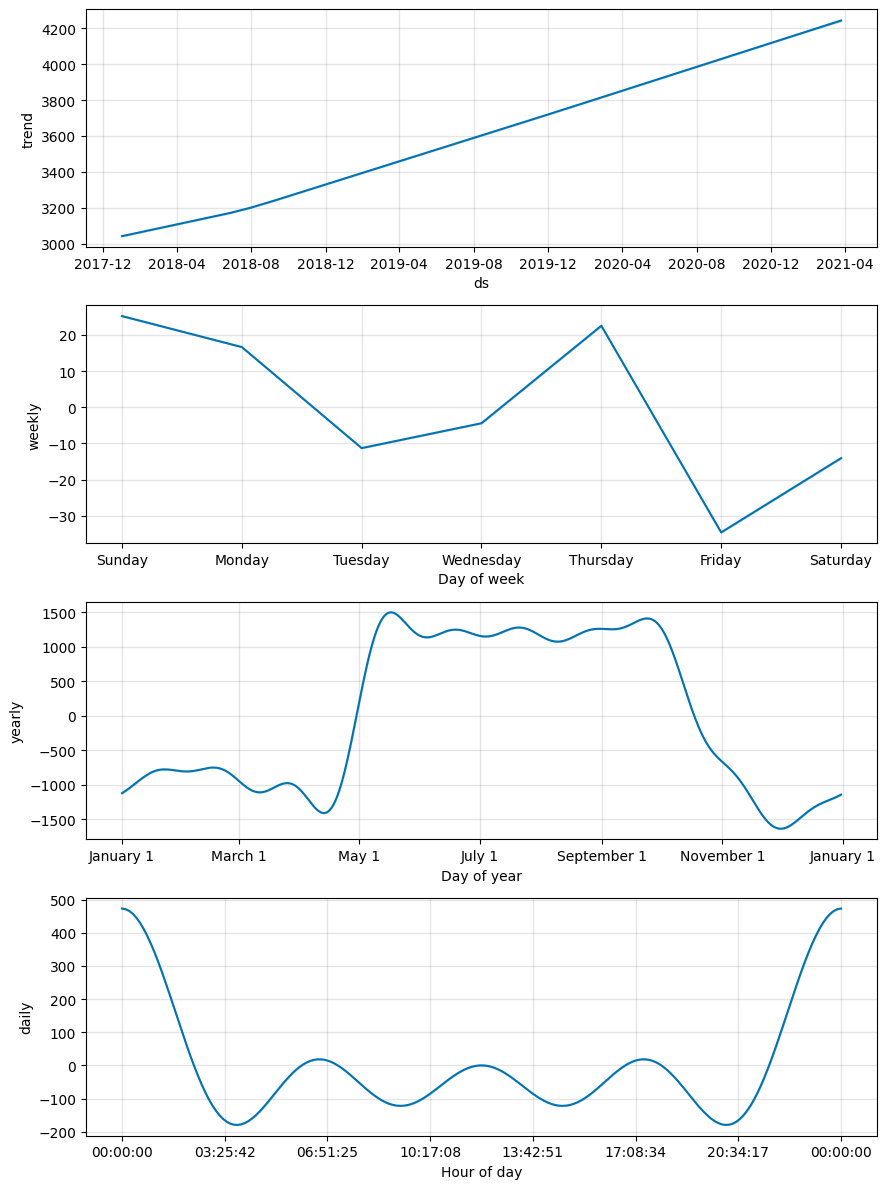

In [18]:
# decompose trend 
plot2 = m.plot_components(forecast)